# Bus flow on road networks in Central London

Bus location data from Bus Open Data Service under OGLv3. Map data © OpenStreetMap contributors under ODbL.

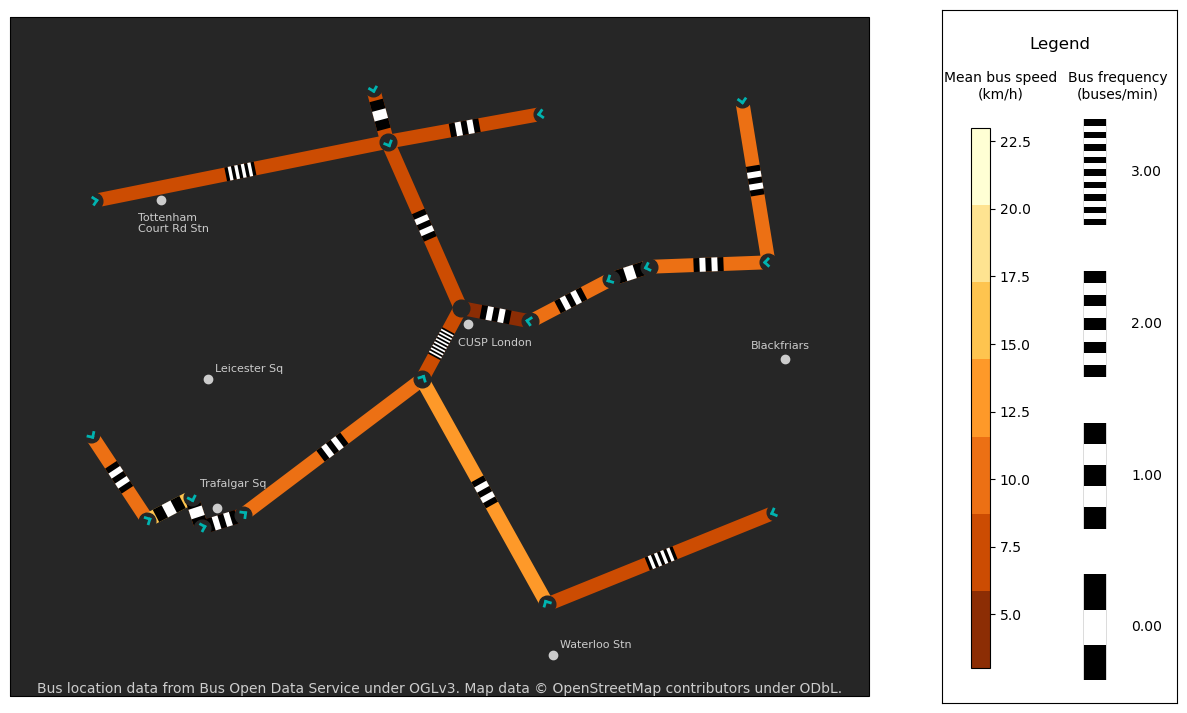

In [3]:
import pandas as pd
import numpy as np
from vizent.vizent_plot import  create_plot, add_lines
from shapely import Point
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
import matplotlib as mpl
import warnings

# Filter warnings for gallery image only
warnings.filterwarnings('ignore')

def transform_wsg_to_bng(pnt):
    return ccrs.epsg(27700).transform_point(pnt.x,pnt.y,src_crs=4326)

df = pd.read_csv('sample-data/bus-open-data-service-sample-network.csv')

starts = []
ends = []
for x,y in df[['start_lon', 'start_lat']].values:
    starts.append(transform_wsg_to_bng(Point(x,y)))
for x,y in df[['end_lon', 'end_lat']].values:
    ends.append(transform_wsg_to_bng(Point(x,y)))

x_starts = [start[0] for start in starts]
y_starts = [start[1] for start in starts]
x_ends = [end[0] for end in ends]
y_ends = [end[1] for end in ends]

vizent_fig = create_plot(use_glyphs=False, 
                         use_lines=True, 
                         use_cartopy=True, 
                         cartopy_projection=ccrs.epsg(27700), 
                         extent=[-0.134693, -0.098987, 51.502702, 51.520076],
                         scale_x=16,
                         scale_y=9, 
                         show_axes=False)

cmapPlain = mpl.colors.ListedColormap(
                list(reversed(['#ffffd4','#fee391','#fec44f','#fe9929',
                               '#ec7014','#cc4c02','#8c2d04'])))

add_lines(vizent_fig,
        x_starts,
        y_starts,
        x_ends, 
        y_ends,  
        df['average_speed'],
        df['distinct_journeys'] / 60.0,
        width_values=[10 for edge in x_starts],
        striped_length=30,
        style='set_length', 
        length_type='pixels',
        color_min=3, 
        color_max=23, 
        freq_min=0, 
        freq_max=3,
        freq_n = 4,
        colormap=cmapPlain, 
        legend_title='Legend', 
        color_label='Mean bus speed\n(km/h)',
        frequency_label='Bus frequency\n(buses/min)',
        label_fontsize=10, 
        interval_type='limit')

ax = vizent_fig[1]

# Plot stops as an angled triangle in the direction of the next edge
for i in range(len(x_starts)):
    dx = [x[0] - y[0] for x,y in zip(ends, starts)][i]
    dy = [x[1] - y[1] for x,y in zip(ends, starts)][i]
    length = np.sqrt(dx**2 + dy**2)    
    chevron_size = 10
    ax.plot([x_starts[i]], [y_starts[i]], c='0.15', marker='o', markersize=12, zorder=1)
    ax.plot([x_starts[i] + (chevron_size / length) * (-dy), 
                        x_starts[i] + (chevron_size / (length)) * dx], 
                    [y_starts[i] + (chevron_size / length) * (dx), 
                        y_starts[i] + (chevron_size / (length)) * dy], 
            linewidth=2, 
            color='#00B3B0', 
            zorder=2)

    ax.plot([x_starts[i] + (chevron_size / length) * (dy), 
                        x_starts[i] + (chevron_size / (length)) * (dx)], 
                    [y_starts[i] + (chevron_size / length) * (-dx), 
                        y_starts[i] + (chevron_size / (length)) * (dy)], 
            linewidth=2, 
            color='#00B3B0', 
            zorder=2)

# Plot the terminating stop
terminating_stop = transform_wsg_to_bng(Point(-0.117465, 51.513173))
ax.plot(terminating_stop[0], terminating_stop[1], marker='o', color='0.15', 
        markersize=12)

#Labels to add: 
landmarks = {'Trafalgar Sq': transform_wsg_to_bng(Point(-0.128011,51.508058)),
            'CUSP London': transform_wsg_to_bng(Point(-0.117180,51.512735)),
            'Waterloo Stn':  transform_wsg_to_bng(Point(-0.113930,51.503941)),
            'Tottenham\nCourt Rd Stn': transform_wsg_to_bng(Point(-0.130028,51.516224)),
            'Blackfriars':  transform_wsg_to_bng(Point(-0.103791,51.511590)),
            'Leicester Sq':  transform_wsg_to_bng(Point(-0.128253,51.511467)), 
            }

offsets = {'Trafalgar Sq': (-50, 60),
            'CUSP London': (-30, -65),
            'Waterloo Stn': (20, 20),
            'Tottenham\nCourt Rd Stn': (-70, -95),
            'Blackfriars':  (-100, 30),
            'Leicester Sq': (20, 20)
            }

for k, v in landmarks.items():
    ax.plot(v[0], v[1], color='0.8', marker='o', markersize=6)
    ax.annotate(k, xy=(v[0]+offsets[k][0], v[1]+offsets[k][1]), color='0.8', fontsize=8,zorder=1110)

ax.text(0.5, 0.02, "Bus location data from Bus Open Data Service under OGLv3. Map data © OpenStreetMap contributors under ODbL.",
horizontalalignment='center',
verticalalignment='top',
fontsize=10,
transform=ax.transAxes,
color='0.8')

# When using cartopy, we can re-draw the physical earth features to change background color.
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='w', facecolor='0.15', zorder=-1))

vizent_fig[0].show()